In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import combinations_with_replacement
from numpy.polynomial.chebyshev import chebval
from sklearn.preprocessing import PolynomialFeatures
from itertools import product

In [33]:
class Zonotope:
    def __init__(self, centre, generators):
        self.centre = np.array(centre).reshape(-1)         # shape (n,)
        self.generators = np.atleast_2d(generators)        # shape (n, m)
        if self.generators.shape[0] != self.centre.shape[0]:
            raise ValueError("Generators must have same dimension as centre")
        self.n = self.centre.shape[0]   # dimension
        self.m = self.generators.shape[1]  # number of generators

    def minkowski_sum(self, other):
        new_centre = self.centre + other.centre
        new_generators = np.hstack((self.generators, other.generators))
        return Zonotope(new_centre, new_generators)
    
    # Outer Approx. of the zonotope - Affine Arithmetic Paper
    def output_interval(self):
        radius = np.sum(np.abs(self.generators), axis=1)  # sum across generators
        lower = self.centre - radius
        upper = self.centre + radius
        return lower, upper

    def affine_map(self, A, b=None):
        new_centre = A @ self.centre + (b if b is not None else 0)
        new_generators = A @ self.generators 
        return Zonotope(new_centre, new_generators)

### Data

In [34]:
df = pd.read_csv('Data/FuelConsumption.csv')
df.head()

car_df = df[['CYLINDERS', 'ENGINE SIZE', 'FUEL', 'FUEL CONSUMPTION', 'COMB (mpg)', 'EMISSIONS']]
car_df.head()

rng = np.random.default_rng(42)  # reproducibility

y = car_df['EMISSIONS'].values

# scale relative to data magnitude
base_scale = 0.1 * np.std(y)

x = car_df['COMB (mpg)'].values
x_scaled = (x - x.min()) / (x.max() - x.min())

radii = base_scale * (0.8 + x_scaled) * np.abs(
    rng.normal(1.0, 0.5, size=len(y))
)

car_df['EMISSIONS_LOWER'] = y - radii
car_df['EMISSIONS_UPPER'] = y + radii


car_df.head()

/tmp/ipykernel_11256/2127995838.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['EMISSIONS_LOWER'] = y - radii
/tmp/ipykernel_11256/2127995838.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['EMISSIONS_UPPER'] = y + radii


,CYLINDERS,ENGINE SIZE,FUEL,FUEL CONSUMPTION,COMB (mpg),EMISSIONS,EMISSIONS_LOWER,EMISSIONS_UPPER
0,4,1.6,X,9.2,35,186,178.078193,193.921807
1,4,1.6,X,8.5,37,175,171.615174,178.384826
2,6,3.2,Z,12.2,28,230,221.398909,238.601091
3,6,3.5,Z,13.4,25,264,255.195142,272.804858
4,4,1.8,X,10.0,33,198,197.836035,198.163965


### Visualisation

Below is the dataset with precise values.

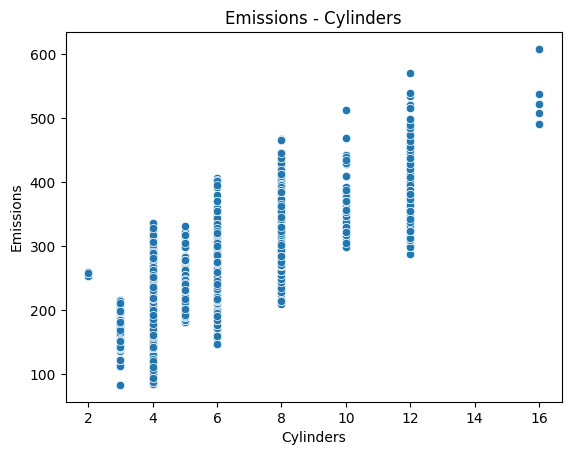

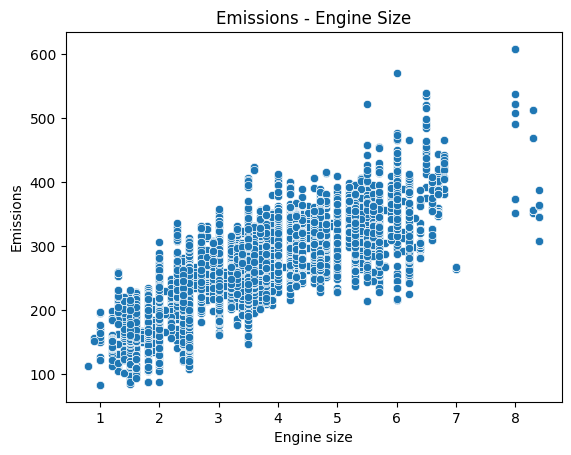

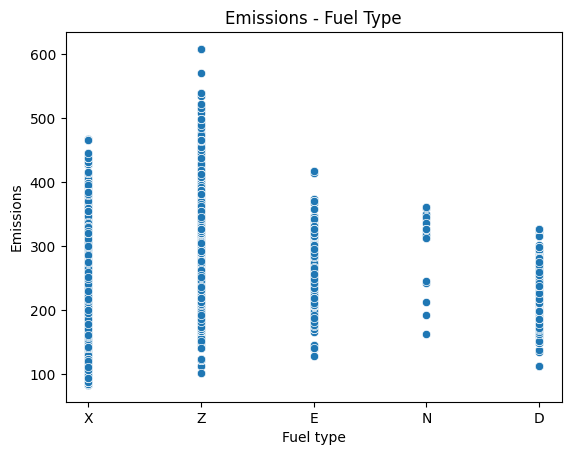

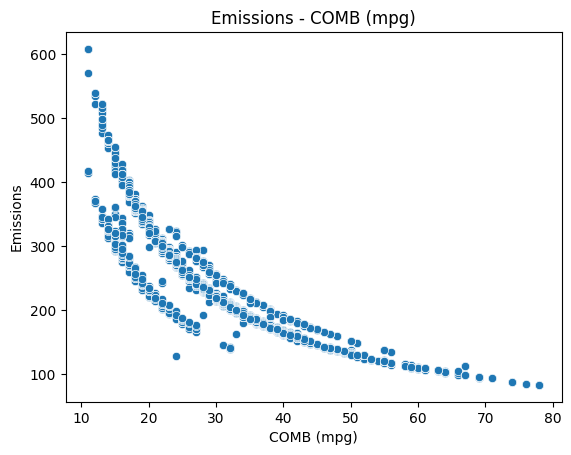

In [35]:
sns.scatterplot(x=car_df['CYLINDERS'], y=car_df['EMISSIONS'])
plt.xlabel("Cylinders")
plt.ylabel("Emissions")
plt.title("Emissions - Cylinders")
plt.show()

sns.scatterplot(x=car_df['ENGINE SIZE'], y=car_df['EMISSIONS'])
plt.xlabel("Engine size")
plt.ylabel("Emissions")
plt.title("Emissions - Engine Size")
plt.show()

sns.scatterplot(x=car_df['FUEL'], y=car_df['EMISSIONS'])
plt.xlabel("Fuel type")
plt.ylabel("Emissions")
plt.title("Emissions - Fuel Type")
plt.show()

sns.scatterplot(x=car_df['COMB (mpg)'], y=car_df['EMISSIONS'])
plt.xlabel("COMB (mpg)")
plt.ylabel("Emissions")
plt.title("Emissions - COMB (mpg)")
plt.show()

Below is the dataset with the new intervalised dependent variable.

### Linear Regression
For this case we only model the relationship between emissions and engine size.

In [36]:
def zonotope_bounds(X, y_lower, y_upper, x_grid=None):
    M = np.linalg.inv(X.T @ X) @ X.T  # shape (n_features, n_samples)

    centre_y = (y_lower + y_upper) / 2
    radii_y = (y_upper - y_lower) / 2
    G_y = np.diag(radii_y)
    Z_y = Zonotope(centre_y, G_y)

    Z_beta = Z_y.affine_map(M)  # shape: n_features x n_samples


    if x_grid is not None:
        y_min, y_max = [], []
        for xg in x_grid:
            # Map zonotope to prediction space: y = Beta0 + Beta1 * x
            Z_pred = Z_beta.affine_map(np.array([[1, xg]]))
            lower, upper = Z_pred.output_interval()
            y_min.append(lower[0])
            y_max.append(upper[0])
        return Z_beta, (np.array(y_min), np.array(y_max))

    return Z_beta

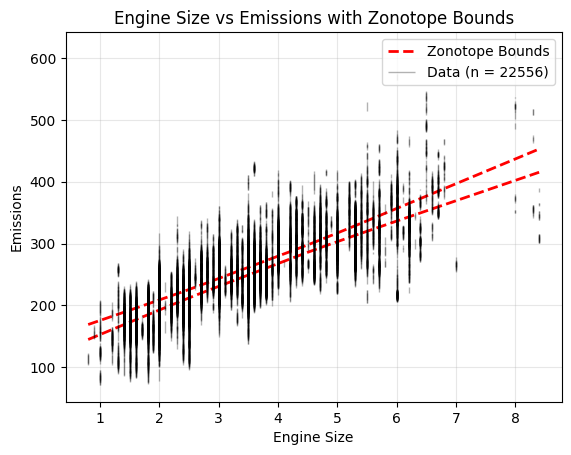

In [37]:
# Prepare the design matrix (add intercept column)
X = np.column_stack([np.ones(len(car_df)), car_df['ENGINE SIZE']])

# Create grid
x_grid = np.linspace(car_df['ENGINE SIZE'].min(), 
                     car_df['ENGINE SIZE'].max(), 
                     100)

_, (y_min, y_max) = zonotope_bounds(
    X,
    car_df['EMISSIONS_LOWER'].values, 
    car_df['EMISSIONS_UPPER'].values, 
    x_grid
)

# Plot the results
plt.plot(x_grid, y_min, '--r', label='Zonotope Bounds', linewidth=2)
plt.plot(x_grid, y_max, '--r', linewidth=2)

n_samples = len(car_df)
for i in range(len(car_df)):
    label = f'Data (n = {n_samples})' if i == 0 else None
    plt.vlines(x=car_df['ENGINE SIZE'].iloc[i], 
               ymin=car_df['EMISSIONS_LOWER'].iloc[i], 
               ymax=car_df['EMISSIONS_UPPER'].iloc[i],
               colors='black', alpha=0.3, linewidth=1, label=label)


plt.xlabel("Engine Size")
plt.ylabel("Emissions")
plt.title("Engine Size vs Emissions with Zonotope Bounds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Multivariate

In [38]:
def multivariate_chebyshev_basis(X, degree=1):
    X = np.asarray(X)
    n_samples, n_features = X.shape

    # Standardize to mean=0, std=1, then clip to [-1,1] for Chebyshev
    X_std = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    X_scaled = np.clip(X_std, -1, 1)

    multi_indices = list(product(range(degree + 1), repeat=n_features))
    
    Phi_list = []
    for multi_idx in multi_indices:
        basis_term = np.ones(n_samples)
        for feature_idx, deg in enumerate(multi_idx):
            if deg > 0:
                coeffs = [0] * deg + [1]
                basis_term *= chebval(X_scaled[:, feature_idx], coeffs)
        Phi_list.append(basis_term)
    
    return np.column_stack(Phi_list)

def nonlinear_zonotope_bounds(
    X, y_lower, y_upper, Phi_grid=None, degree=2, regularization=1e-3
):
    X = np.asarray(X)
    y_lower = np.asarray(y_lower).reshape(-1)
    y_upper = np.asarray(y_upper).reshape(-1)

    centre_y = (y_lower + y_upper) / 2
    radii_y = (y_upper - y_lower) / 2

    # Basis
    Phi = multivariate_chebyshev_basis(X, degree)

    # Regularized least-squares (helps with conditioning)
    M = np.linalg.inv(Phi.T @ Phi + regularization * np.eye(Phi.shape[1])) @ Phi.T

    # Output zonotope
    Y_zono = Zonotope(centre_y, np.diag(radii_y))

    # Parameter zonotope
    Beta_zono = Y_zono.affine_map(M)

    # Prediction on samples
    if Phi_grid is not None:
        Yhat_zono = Beta_zono.affine_map(Phi_grid)
        y_lower_pred, y_upper_pred = Yhat_zono.output_interval()
        return Beta_zono, Yhat_zono, y_lower_pred, y_upper_pred

    return Beta_zono

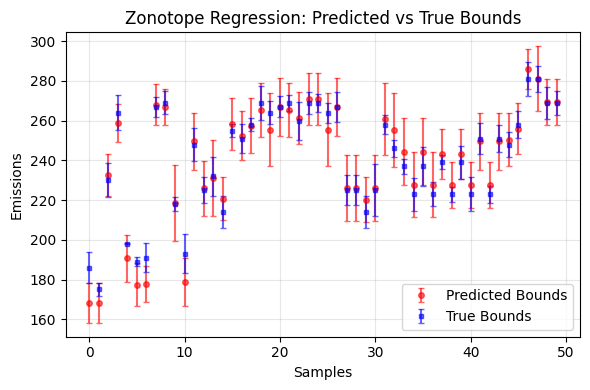

In [39]:
features = ['CYLINDERS', 'ENGINE SIZE', 'FUEL CONSUMPTION', 'COMB (mpg)']
X = car_df[features].values 

Phi_data = multivariate_chebyshev_basis(X, degree=1)

_, _, y_lower_pred, y_upper_pred = nonlinear_zonotope_bounds(
    X,
    car_df['EMISSIONS_LOWER'].values,
    car_df['EMISSIONS_UPPER'].values,
    Phi_grid=Phi_data,
    degree=1
)

y_centre_pred = 0.5 * (y_lower_pred + y_upper_pred)
y_centre_true = 0.5 * (car_df['EMISSIONS_LOWER'].values + car_df['EMISSIONS_UPPER'].values)


fig, ax = plt.subplots(figsize=(6, 4))

n_plot = min(50, len(y_centre_pred))
indices = np.arange(n_plot)

# Plot predicted bounds
ax.errorbar(
    indices,
    y_centre_pred[:n_plot],
    yerr=[
        y_centre_pred[:n_plot] - y_lower_pred[:n_plot],
        y_upper_pred[:n_plot] - y_centre_pred[:n_plot]
    ],
    fmt='o',
    markersize=4,
    alpha=0.6,
    capsize=2,
    color='red',
    label='Predicted Bounds'
)

# Plot true bounds
ax.errorbar(
    indices,
    y_centre_true[:n_plot],
    yerr=[
        y_centre_true[:n_plot] - car_df['EMISSIONS_LOWER'].values[:n_plot],
        car_df['EMISSIONS_UPPER'].values[:n_plot] - y_centre_true[:n_plot]
    ],
    fmt='s',
    markersize=3,
    alpha=0.6,
    capsize=2,
    color='blue',
    label='True Bounds'
)

ax.set_xlabel('Samples')
ax.set_ylabel('Emissions')
ax.set_title('Zonotope Regression: Predicted vs True Bounds')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()